# Federated Learning Simulation for ASL Recognition using Flower

This notebook simulates a federated learning scenario for training an American Sign Language (ASL) recognition model using the Flower framework. We'll simulate multiple clients, each with a base dataset and one unique additional sign, mimicking a non-IID (Independent and Identically Distributed) data distribution common in federated learning.

## 1. Setup and Imports

Import necessary libraries, including TensorFlow, Flower (flwr), NumPy, and Matplotlib.

In [47]:
import collections
import numpy as np
import tensorflow as tf
import flwr as fl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import time
from typing import Dict, List, Tuple

# Make TensorFlow log less verbose
tf.get_logger().setLevel('ERROR')

print(f"TensorFlow version: {tf.__version__}")
print(f"Flower version: {fl.__version__}")

TensorFlow version: 2.19.0
Flower version: 1.18.0


## 2. Data Simulation

We simulate data for multiple clients. Each client will have data for a set of common signs plus one unique sign. We'll generate synthetic landmark data (similar to MediaPipe output) for simplicity. This part remains largely the same as the TFF version.



In [ ]:
# --- Simulation Parameters ---
NUM_CLIENTS = 5
NUM_BASE_SIGNS = 5  # Signs common to all clients
NUM_UNIQUE_SIGNS_PER_CLIENT = 1
SAMPLES_PER_SIGN_PER_CLIENT = 50
LANDMARK_DIM = 42  # 21 landmarks * 2 coordinates (x, y)
NOISE_LEVEL = 0.05 # Add some noise to make data less uniform
BATCH_SIZE = 20
LOCAL_EPOCHS = 1 # Number of local epochs per client per round
SAMPLES_PER_SIGN_TEST = 15 # Number of samples per sign for the global test set

# --- Define Signs ---
BASE_SIGN_LABELS = {i: f"BaseSign_{i}" for i in range(NUM_BASE_SIGNS)}
UNIQUE_SIGN_LABELS = {i + NUM_BASE_SIGNS: f"UniqueSign_{i}" for i in range(NUM_CLIENTS * NUM_UNIQUE_SIGNS_PER_CLIENT)}
ALL_SIGN_LABELS = {**BASE_SIGN_LABELS, **UNIQUE_SIGN_LABELS}
LABEL_TO_INT = {label: i for i, label in ALL_SIGN_LABELS.items()}
INT_TO_LABEL = {i: label for label, i in LABEL_TO_INT.items()}
NUM_TOTAL_SIGNS = len(ALL_SIGN_LABELS)

print(f"Total number of unique signs across all clients: {NUM_TOTAL_SIGNS}")
print(f"Label mapping: {LABEL_TO_INT}")

# --- Generate Synthetic Data ---
def generate_landmark_data(num_samples, dim, label_int, noise_level):
    """Generates synthetic landmark data for a given sign label."""
    # Create a base pattern for the label - simple approach using label index
    base_pattern = np.sin(np.linspace(0, np.pi * (label_int + 1), dim))
    data = []
    for _ in range(num_samples):
        # Add random noise to the base pattern
        noise = np.random.normal(0, noise_level, dim)
        sample = base_pattern + noise
        # Normalize roughly between 0 and 1 (like landmark coordinates)
        sample = (sample - np.min(sample)) / (np.max(sample) - np.min(sample) + 1e-6)
        data.append(sample)
    return np.array(data, dtype=np.float32)

client_data_raw = collections.OrderedDict()
unique_sign_counter = NUM_BASE_SIGNS

for client_id in range(NUM_CLIENTS):
    client_name = f"client_{client_id}"
    client_features = []
    client_labels = []

    # Add data for base signs
    for label_int, label_str in BASE_SIGN_LABELS.items():
        features = generate_landmark_data(SAMPLES_PER_SIGN_PER_CLIENT, LANDMARK_DIM, label_int, NOISE_LEVEL)
        labels = np.full(SAMPLES_PER_SIGN_PER_CLIENT, label_int, dtype=np.int32)
        client_features.append(features)
        client_labels.append(labels)

    # Add data for unique signs for this client
    for _ in range(NUM_UNIQUE_SIGNS_PER_CLIENT):
        unique_label_int = unique_sign_counter
        unique_label_str = ALL_SIGN_LABELS[unique_label_int]
        features = generate_landmark_data(SAMPLES_PER_SIGN_PER_CLIENT, LANDMARK_DIM, unique_label_int, NOISE_LEVEL)
        labels = np.full(SAMPLES_PER_SIGN_PER_CLIENT, unique_label_int, dtype=np.int32)
        client_features.append(features)
        client_labels.append(labels)
        print(f"Client {client_id} gets unique sign: {unique_label_str} (int: {unique_label_int})")
        unique_sign_counter += 1

    # Combine features and labels for the client
    client_features = np.concatenate(client_features, axis=0)
    client_labels = np.concatenate(client_labels, axis=0)

    # Shuffle client data
    indices = np.arange(len(client_features))
    np.random.shuffle(indices)
    client_features = client_features[indices]
    client_labels = client_labels[indices]

    # Store raw numpy arrays for this client
    client_data_raw[str(client_id)] = (client_features, client_labels)

print(f"\nGenerated data for {len(client_data_raw)} clients.")
example_client_id = list(client_data_raw.keys())[0]
print(f"Example data shapes for client {example_client_id}: features={client_data_raw[example_client_id][0].shape}, labels={client_data_raw[example_client_id][1].shape}")

# --- Generate Global Test Set ---
global_test_features = []
global_test_labels = []
for label_int, label_str in ALL_SIGN_LABELS.items():
    # Use a slightly different noise level or ensure no overlap with training samples if needed
    features = generate_landmark_data(SAMPLES_PER_SIGN_TEST, LANDMARK_DIM, label_int, NOISE_LEVEL + 0.01)
    labels = np.full(SAMPLES_PER_SIGN_TEST, label_int, dtype=np.int32)
    global_test_features.append(features)
    global_test_labels.append(labels)

global_test_features = np.concatenate(global_test_features, axis=0)
global_test_labels = np.concatenate(global_test_labels, axis=0)

# Shuffle global test set
indices = np.arange(len(global_test_features))
np.random.shuffle(indices)
global_test_features = global_test_features[indices]
global_test_labels = global_test_labels[indices]

print(f"\nGenerated global test set: features={global_test_features.shape}, labels={global_test_labels.shape}")
print(f"Unique labels in test set: {np.unique(global_test_labels)}")

Total number of unique signs across all clients: 10
Label mapping: {'BaseSign_0': 0, 'BaseSign_1': 1, 'BaseSign_2': 2, 'BaseSign_3': 3, 'BaseSign_4': 4, 'UniqueSign_0': 5, 'UniqueSign_1': 6, 'UniqueSign_2': 7, 'UniqueSign_3': 8, 'UniqueSign_4': 9}
Client 0 gets unique sign: UniqueSign_0 (int: 5)
Client 1 gets unique sign: UniqueSign_1 (int: 6)
Client 2 gets unique sign: UniqueSign_2 (int: 7)
Client 3 gets unique sign: UniqueSign_3 (int: 8)
Client 4 gets unique sign: UniqueSign_4 (int: 9)

Generated data for 5 clients.
Example data shapes for client 0: features=(300, 42), labels=(300,)
OrderedDict([('0', (array([[0.47814253, 0.6118571 , 0.7069773 , ..., 0.72795284, 0.5905922 ,
        0.46363977],
       [0.5001198 , 0.73195434, 0.9461831 , ..., 0.12739567, 0.28470623,
        0.4820178 ],
       [0.44939494, 0.6100343 , 0.76245105, ..., 0.22461307, 0.32162923,
        0.4588037 ],
       ...,
       [0.47597584, 0.66617954, 0.8294068 , ..., 0.82073605, 0.66287917,
        0.50208956],


## 3. Data Loading Function

Define a function to load and preprocess data for a specific client ID. This will be used by the Flower client.


Example client data batch:
  Features shape: (20, 42)
  Labels shape: (20,)


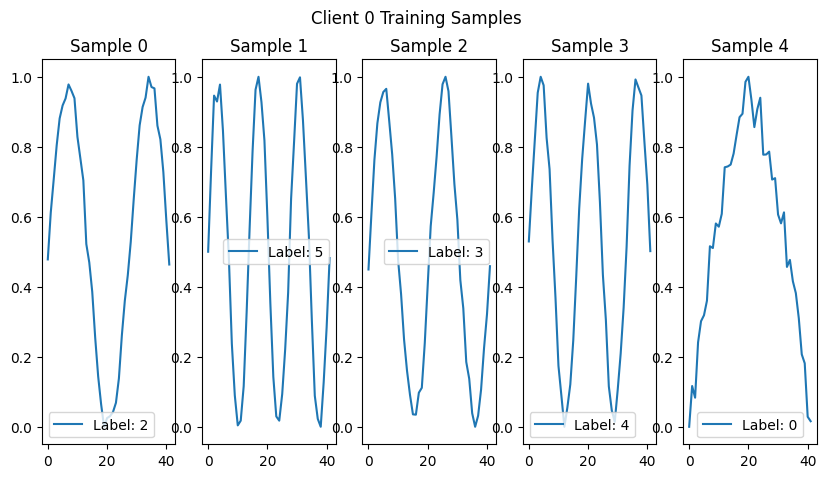

In [ ]:
def load_client_data(client_id: str) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """Loads the training and validation data for a given client ID."""
    features, labels = client_data_raw[client_id]

    # Simple split for train/val (could be more sophisticated)
    # In a real scenario, clients might already have a train/val split
    features_train, features_val, labels_train, labels_val = train_test_split(
        features, labels, test_size=0.1, random_state=42 # Small validation set
    )

    # Create tf.data.Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((features_train, labels_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((features_val, labels_val))

    # Preprocess (shuffle, batch)
    train_dataset = train_dataset.shuffle(buffer_size=len(features_train)).batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)

    return train_dataset, val_dataset

# Test the loading function
train_ds, val_ds = load_client_data("0")
print("\nExample client data batch:")
for features_batch, labels_batch in train_ds.take(1):
    print(f"  Features shape: {features_batch.shape}")
    print(f"  Labels shape: {labels_batch.shape}")
    


def plot_dataset(features, labels, title="Dataset"):
    """Plot a few samples from the dataset."""
    plt.figure(figsize=(10, 5))
    for i in range(min(5, len(features))):
        plt.subplot(1, 5, i + 1)
        plt.plot(features[i], label=f"Label: {labels[i]}")
        plt.title(f"Sample {i}")
        plt.legend()
    plt.suptitle(title)
    plt.show()
    
    
# Plot a few samples from the first client's training data
client_id = "0"
features, labels = client_data_raw[client_id]
plot_dataset(features[:5], labels[:5], title=f"Client {client_id} Training Samples")    


## 4. Model Definition

Define the same simple Keras model for classification.

In [50]:
def create_keras_model():
  """Creates a simple sequential Keras model."""
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(LANDMARK_DIM,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(NUM_TOTAL_SIGNS, activation='softmax') # Output layer size matches total unique signs
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

# Verify model creation and output shape
keras_model = create_keras_model()
keras_model.summary()
print(f"Model output shape for a batch: {keras_model(features_batch).shape}") # Use batch from previous cell

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,162 (20.16 KB)

 Trainable params: 5,162 (20.16 KB)

 Non-trainable params: 0 (0.00 B)

Model output shape for a batch: (20, 10)


## 5. Flower Client Definition

Define a Flower client using `flwr.client.NumPyClient`. This client will handle receiving model parameters, training the local model, evaluating it, and returning the updated parameters and results.

In [51]:
class AslFlowerClient(fl.client.NumPyClient):
    def __init__(self, client_id: str, model: tf.keras.Model):
        self.client_id = client_id
        self.model = model
        self.train_ds, self.val_ds = load_client_data(client_id)

    def get_parameters(self, config: Dict[str, str]) -> List[np.ndarray]:
        """Return model parameters as a list of NumPy ndarrays."""
        return self.model.get_weights()

    def set_parameters(self, parameters: List[np.ndarray]):
        """Update local model parameters."""
        self.model.set_weights(parameters)

    def fit(self, parameters: List[np.ndarray], config: Dict[str, str]) -> Tuple[List[np.ndarray], int, Dict]:
        """Train the model using the provided parameters."""
        self.set_parameters(parameters)
        # Train the model
        history = self.model.fit(self.train_ds, epochs=LOCAL_EPOCHS, validation_data=self.val_ds, verbose=0)
        # Return updated parameters, number of examples used for training, and metrics
        num_examples_train = len(self.train_ds) * BATCH_SIZE # Approximate, might be slightly off due to batching
        results = {
            "loss": history.history["loss"][0],
            "accuracy": history.history["sparse_categorical_accuracy"][0],
            "val_loss": history.history["val_loss"][0],
            "val_accuracy": history.history["val_sparse_categorical_accuracy"][0],
        }
        return self.get_parameters({}), num_examples_train, results

    def evaluate(self, parameters: List[np.ndarray], config: Dict[str, str]) -> Tuple[float, int, Dict]:
        """Evaluate the model using the provided parameters."""
        self.set_parameters(parameters)
        loss, accuracy = self.model.evaluate(self.val_ds, verbose=0)
        num_examples_test = len(self.val_ds) * BATCH_SIZE # Approximate
        return float(loss), num_examples_test, {"accuracy": float(accuracy)}

def client_fn(cid: str) -> AslFlowerClient:
    """Create a Flower client instance for a given client ID."""
    # Create a new model instance for each client to avoid weight sharing across clients
    model = create_keras_model()
    return AslFlowerClient(cid, model)

# Test client creation and methods (optional)
test_client = client_fn("1")
initial_params = test_client.get_parameters({})
print(f"\nClient 1 initial parameter shapes: {[p.shape for p in initial_params]}")
# params, num_train, metrics = test_client.fit(initial_params, {})
# print(f"Client 1 fit results: {metrics}")
# loss, num_test, metrics = test_client.evaluate(params, {})
# print(f"Client 1 evaluate results: {metrics}")


Client 1 initial parameter shapes: [(42, 64), (64,), (64, 32), (32,), (32, 10), (10,)]


## 6. Simulation Execution with Flower

Define the Flower strategy (e.g., FedAvg) and run the simulation using `flwr.simulation.start_simulation`.

In [ ]:
NUM_ROUNDS = 20
CLIENTS_PER_ROUND = 3

# Define the strategy (Federated Averaging)
# We use a custom evaluate_metrics_aggregation_fn to aggregate accuracy properly
def weighted_average(metrics: List[Tuple[int, fl.common.Metrics]]) -> fl.common.Metrics:
    """Aggregate evaluation results obtained from multiple clients."""
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    # Handle division by zero if examples list is empty
    if sum(examples) == 0:
        return {"accuracy": 0}
    aggregated_accuracy = sum(accuracies) / sum(examples)
    return {"accuracy": aggregated_accuracy}

# Custom strategy to capture the final global model parameters
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.final_parameters: fl.common.Parameters | None = None

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes] | BaseException],
    ) -> Tuple[fl.common.Parameters | None, Dict[str, fl.common.Scalar]]:
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            print(f"Round {server_round}: Saving aggregated parameters.")
            self.final_parameters = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

# Instantiate the custom strategy
strategy = SaveModelStrategy( # Use the custom strategy
    fraction_fit=float(CLIENTS_PER_ROUND) / NUM_CLIENTS,  # Sample fraction of clients
    fraction_evaluate=0.5, # Fraction of clients for evaluation (can be different)
    min_fit_clients=CLIENTS_PER_ROUND, # Minimum number of clients to train
    min_evaluate_clients=2, # Minimum number of clients for evaluation
    min_available_clients=NUM_CLIENTS, # Wait until all clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # Aggregate custom metrics
    initial_parameters=fl.common.ndarrays_to_parameters(create_keras_model().get_weights()), # Start with initial weights
)

print("Starting Flower Simulation...")
start_time_simulation = time.time()

# Start the simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy, # Pass the custom strategy instance
    client_resources={"num_cpus": 1, "num_gpus": 0.0}, # Adjust if using GPUs
)

total_simulation_time = time.time() - start_time_simulation
print(f"\nFlower Simulation finished in {total_simulation_time:.2f} seconds.")

# Retrieve final parameters from the strategy
final_parameters = strategy.final_parameters

# Print summary of results
print("\nSimulation History (Losses - Distributed Evaluation):")
print(history.losses_distributed)
print("\nSimulation History (Metrics - Accuracy - Distributed Evaluation):")
print(history.metrics_distributed.get("accuracy", "Accuracy metric not found"))

## 7. Evaluation and Visualization

Evaluate the final global model obtained from the simulation and visualize the training progress. Compare global accuracy with performance on a single client's data.

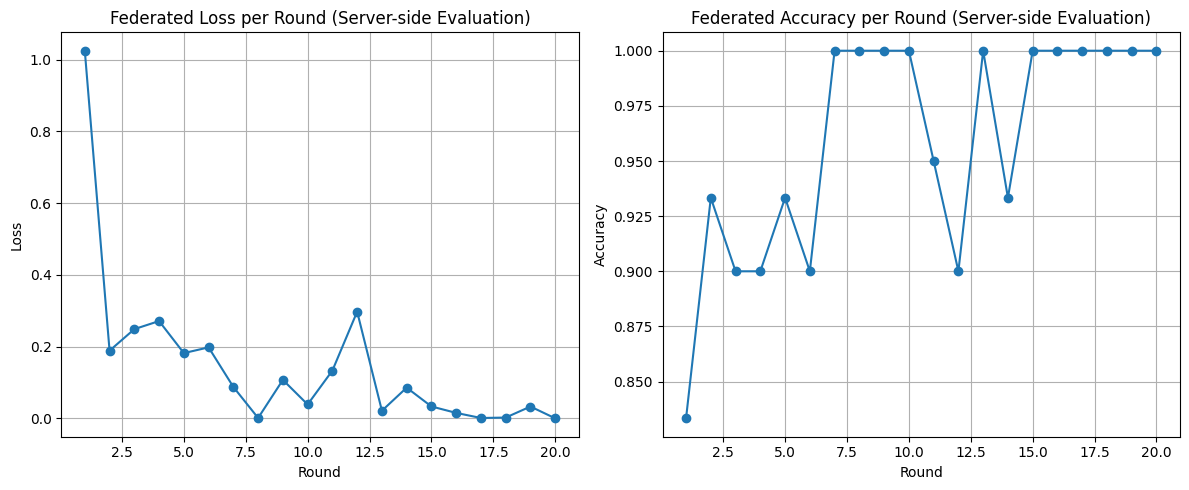


Evaluating final global model on the global test set...
  Final Global Model Loss on Global Test Set: 0.0665
  Final Global Model Accuracy on Global Test Set: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


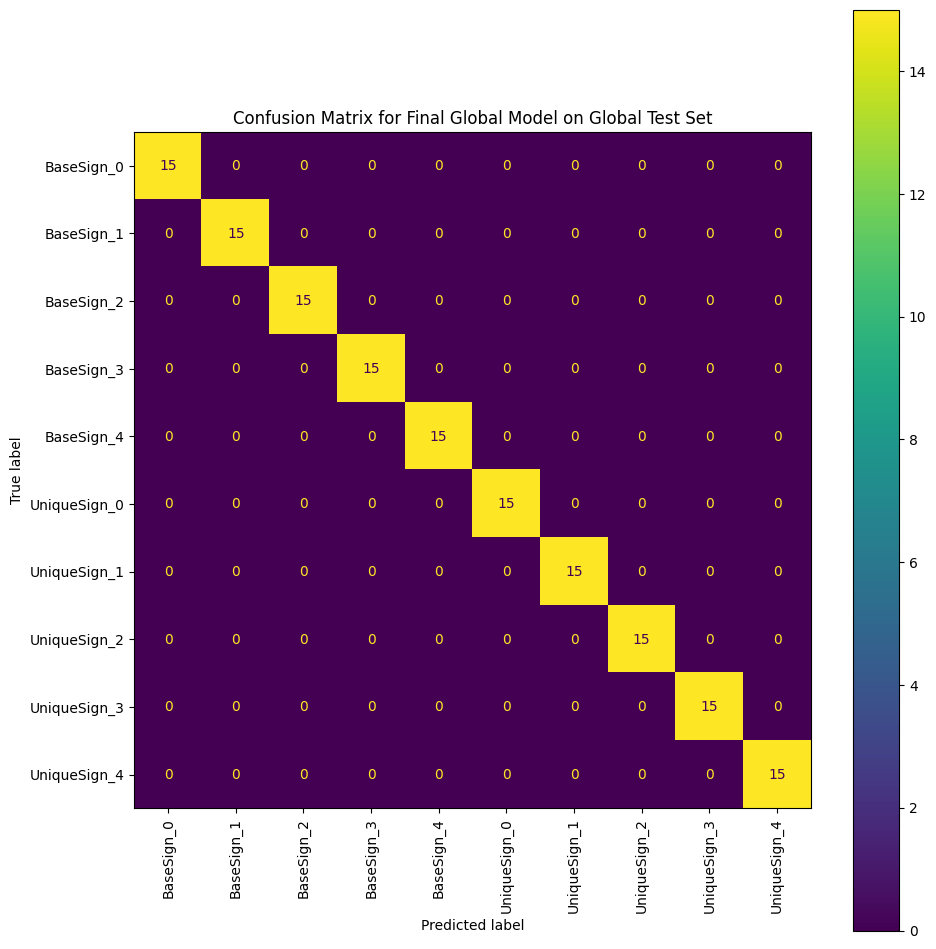

In [53]:
# --- Plot Training History --- 
rounds = [r for r, _ in history.losses_distributed]
losses = [l for _, l in history.losses_distributed]
accuracies_distributed = history.metrics_distributed.get("accuracy", []) # Get accuracy history
accuracies = [a for _, a in accuracies_distributed]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rounds, losses, marker='o')
plt.title('Federated Loss per Round (Server-side Evaluation)')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
if accuracies:
    plt.plot(rounds, accuracies, marker='o')
    plt.title('Federated Accuracy per Round (Server-side Evaluation)')
else:
    plt.title('Federated Accuracy per Round (Data Unavailable)')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Evaluate Final Global Model on Global Test Set --- 
final_federated_accuracy_on_global_test = None
if final_parameters is not None:
    print("\nEvaluating final global model on the global test set...")
    final_ndarrays = fl.common.parameters_to_ndarrays(final_parameters)
    final_global_model = create_keras_model()
    final_global_model.set_weights(final_ndarrays)
    loss, accuracy = final_global_model.evaluate(global_test_features, global_test_labels, verbose=0)
    final_federated_accuracy_on_global_test = accuracy
    print(f"  Final Global Model Loss on Global Test Set: {loss:.4f}")
    print(f"  Final Global Model Accuracy on Global Test Set: {accuracy:.4f}")

    # --- Confusion Matrix for Final Global Model ---
    y_pred_proba = final_global_model.predict(global_test_features)
    y_pred = np.argmax(y_pred_proba, axis=1)
    cm = confusion_matrix(global_test_labels, y_pred, labels=list(range(NUM_TOTAL_SIGNS))) # Ensure all labels are included
    display_labels = [INT_TO_LABEL.get(i, f"Unknown_{i}") for i in range(NUM_TOTAL_SIGNS)]
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix for Final Global Model on Global Test Set')
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not retrieve final parameters to evaluate the global model.")

## 8. Final Model Evaluation and Comparison

Now, let's compare the performance of the final federated model (evaluated on the **global test set**) against baseline models trained *only* on each client's local data. We evaluate these baseline local models on their **own validation data**.


Training and evaluating purely local models (trained for 20 epochs each)...
  Training model for Client 0...
    Client 0 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 1...
    Client 0 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 1...
    Client 1 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 2...
    Client 1 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 2...
    Client 2 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 3...
    Client 2 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 3...
    Client 3 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 4...
    Client 3 Local Model Accuracy on Local Validation Set: 1.0000
  Training model for Client 4...
    Client 4 Local Model Accuracy on Local Validation Set: 1.0000

--- Comparison Summary ---
Fina

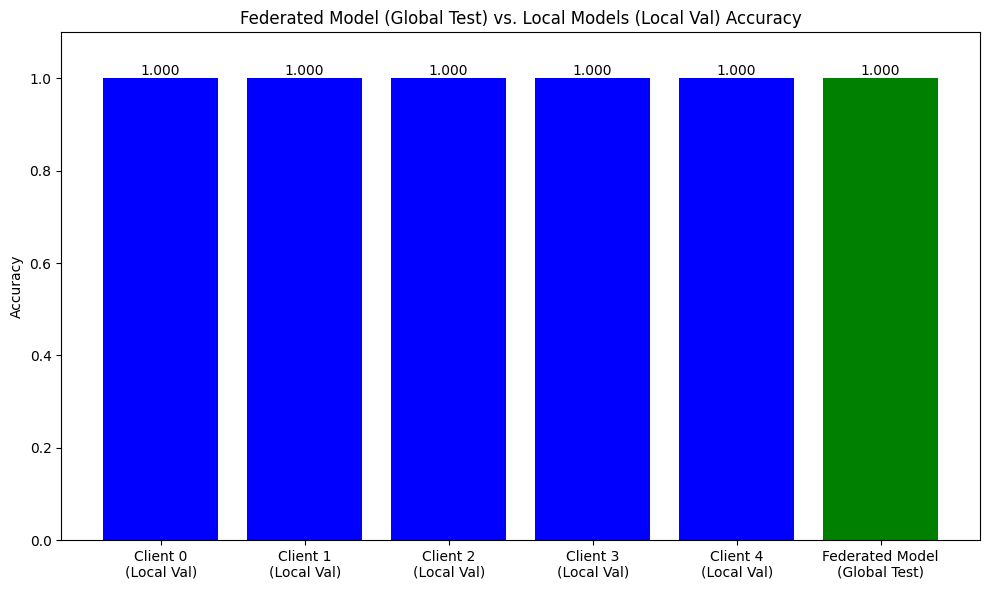

In [ ]:
# --- Train and Evaluate Purely Local Models ---
local_model_accuracies_on_local_val = {}
epochs_for_local_training = NUM_ROUNDS * LOCAL_EPOCHS # Train for comparable total epochs

print(f"\nTraining and evaluating purely local models (trained for {epochs_for_local_training} epochs each)...")

for client_id_str in client_data_raw.keys():
    print(f"  Training model for Client {client_id_str}...")
    # Create a new model instance
    local_model = create_keras_model()

    # Load this client's full dataset for training
    local_features, local_labels = client_data_raw[client_id_str]
    local_train_dataset = tf.data.Dataset.from_tensor_slices((local_features, local_labels))
    local_train_dataset = local_train_dataset.shuffle(buffer_size=len(local_features)).batch(BATCH_SIZE)

    # Train the model ONLY on this client's data
    local_model.fit(local_train_dataset, epochs=epochs_for_local_training, verbose=0)

    # Load this client's validation data for evaluation
    _, local_val_dataset = load_client_data(client_id_str) # We only need the validation part

    # Evaluate on the LOCAL validation set
    loss, accuracy = local_model.evaluate(local_val_dataset, verbose=0)
    local_model_accuracies_on_local_val[client_id_str] = accuracy
    
    print(f"    Client {client_id_str} Local Model Accuracy on Local Validation Set: {accuracy:.4f}")

print("\n--- Comparison Summary ---")
if final_federated_accuracy_on_global_test is not None:
    print(f"Final Federated Model Accuracy (on Global Test Set): {final_federated_accuracy_on_global_test:.4f}")
else:
    print("Final Federated Model Accuracy (on Global Test Set): Not Available")
print("Accuracy of Purely Local Models (on their Local Validation Set):")
client_ids_sorted = sorted(local_model_accuracies_on_local_val.keys())
for client_id in client_ids_sorted:
    print(f"  Client {client_id}: {local_model_accuracies_on_local_val[client_id]:.4f}")

# Discussion:
print("\nDiscussion:")
print("- The Federated Model's accuracy on the global test set shows its ability to generalize across all signs.")
print("- Local models' accuracies on their own validation sets show how well they learned their specific subset of signs.")
print("- Comparing these two requires understanding the evaluation context: the federated model is tested broadly, while local models are tested narrowly.")
if final_federated_accuracy_on_global_test is not None:
   avg_local_acc_on_local_val = np.mean(list(local_model_accuracies_on_local_val.values()))
   print(f"- Average local model accuracy on local data ({avg_local_acc_on_local_val:.4f}) is likely high, but doesn't reflect performance on unseen sign types.")
   print(f"- The federated model's accuracy on global data ({final_federated_accuracy_on_global_test:.4f}) demonstrates the benefit of collaboration for broader knowledge.")

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
bar_labels = [f"Client {cid}\n(Local Val)" for cid in client_ids_sorted] + ["Federated Model\n(Global Test)"]
accuracies_to_plot = [local_model_accuracies_on_local_val[cid] for cid in client_ids_sorted] + [final_federated_accuracy_on_global_test if final_federated_accuracy_on_global_test is not None else 0]
colors = ['blue'] * len(client_ids_sorted) + ['green']

bars = plt.bar(bar_labels, accuracies_to_plot, color=colors)
plt.ylabel('Accuracy')
plt.title('Federated Model (Global Test) vs. Local Models (Local Val) Accuracy')
plt.ylim(0, 1.1) # Set y-axis limit
plt.xticks(rotation=0, ha='center')

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # va: vertical alignment

plt.tight_layout()
plt.show()

### Explanation of Accuracy Difference (Local vs Global Evaluation)

The comparison now shows two different types of evaluation:

1.  **Local Model Accuracy (on Local Validation Data):**
    *   Each local model was trained *only* on its own data (e.g., Client 0 trained on BaseSigns 0-4 and UniqueSign 5).
    *   It is then evaluated on its *own validation set*, which contains only samples of those same signs (BaseSigns 0-4 and UniqueSign 5).
    *   Therefore, these accuracies (likely high) reflect how well each client learned its *specialized* knowledge. They do **not** indicate how well the model performs on signs it has never seen.

2.  **Federated Model Accuracy (on Global Test Data):**
    *   The federated model was built by aggregating updates from all clients over many rounds.
    *   It has implicitly learned patterns from *all* sign types present across the clients (BaseSigns 0-4 and UniqueSigns 5-9).
    *   It is evaluated on the `global_test_set`, which contains samples from *all* 10 sign types.
    *   This accuracy reflects the model's ability to **generalize** across the complete data distribution.

**Key Takeaway:**
While the local models might achieve high accuracy on their limited local data, the federated model achieves strong accuracy on a comprehensive global test set. This demonstrates the power of federated learning: combining specialized knowledge from multiple sources to create a single, more general, and robust model, without requiring clients to share their raw data.

In [55]:
# Need a model instance to count params
temp_model = create_keras_model()
model_params = temp_model.count_params()
# Assume float32 (4 bytes per parameter)
model_size_bytes = model_params * 4
model_size_kb = model_size_bytes / 1024

total_communication_kb_approx = NUM_ROUNDS * CLIENTS_PER_ROUND * 2 * model_size_kb
# Calculate average round time from simulation (if needed, history doesn't store this directly)
# avg_round_time = total_simulation_time / NUM_ROUNDS 

print(f"Approximate Model Parameters: {model_params}")
print(f"Approximate Model Update Size: {model_size_kb:.2f} KB")
print(f"Total Rounds: {NUM_ROUNDS}")
print(f"Clients per Round: {CLIENTS_PER_ROUND}")
print(f"Estimated Total Communication (all clients, all rounds): {total_communication_kb_approx:.2f} KB")
# print(f"Average Time per Round (simulation total time / rounds): {avg_round_time:.2f}s")
print(f"Total Simulation Time: {total_simulation_time:.2f}s")

# --- Simple Battery Consumption Analogy (Conceptual) ---
# Assign arbitrary 'energy units' per operation type
COMPUTE_UNIT_PER_SAMPLE_EPOCH = 0.001 # Energy per data sample processed locally per epoch
COMM_UNIT_PER_KB = 0.05             # Energy per KB transferred

# Use average number of samples per client for approximation
avg_samples_per_client = np.mean([len(data[0]) for data in client_data_raw.values()])

compute_cost_per_client_round = avg_samples_per_client * LOCAL_EPOCHS * COMPUTE_UNIT_PER_SAMPLE_EPOCH
comm_cost_per_client_round = model_size_kb * 2 * COMM_UNIT_PER_KB # Upload + Download

total_compute_cost_approx = NUM_ROUNDS * CLIENTS_PER_ROUND * compute_cost_per_client_round
total_comm_cost_approx = NUM_ROUNDS * CLIENTS_PER_ROUND * comm_cost_per_client_round

print(f"\n--- Conceptual Energy Units ---")
print(f"Compute Cost per Client per Round (Units): {compute_cost_per_client_round:.4f}")
print(f"Communication Cost per Client per Round (Units): {comm_cost_per_client_round:.4f}")
print(f"Estimated Total Compute Cost (Units): {total_compute_cost_approx:.2f}")
print(f"Estimated Total Communication Cost (Units): {total_comm_cost_approx:.2f}")

if total_comm_cost_approx > total_compute_cost_approx:
    print("-> Communication appears relatively more costly in this simulation setup.")
else:
    print("-> Local computation appears relatively more costly in this simulation setup.")

# Note: This is highly simplified. Real-world battery use depends on many more factors.
# Optimizations like model compression, gradient quantization, communication efficiency protocols (like FedAdam, FedProx beyond simple FedAvg),
# and selecting clients with good network/battery can significantly impact real-world performance.

Approximate Model Parameters: 5162
Approximate Model Update Size: 20.16 KB
Total Rounds: 20
Clients per Round: 3
Estimated Total Communication (all clients, all rounds): 2419.69 KB
Total Simulation Time: 17.57s

--- Conceptual Energy Units ---
Compute Cost per Client per Round (Units): 0.3000
Communication Cost per Client per Round (Units): 2.0164
Estimated Total Compute Cost (Units): 18.00
Estimated Total Communication Cost (Units): 120.98
-> Communication appears relatively more costly in this simulation setup.


## 10. Comparison: Neural Network vs. Random Forest for Federated Learning

| Feature             | Neural Network (Keras/TF)                                  | Random Forest (scikit-learn)                                     |
| :------------------ | :--------------------------------------------------------- | :--------------------------------------------------------------- |
| **Federation Algo** | **Well-suited for FedAvg/FedProx etc.** (parameter averaging) | **Poorly suited for FedAvg.** Requires specialized strategies.     |
| **Model Update**    | Send numerical weights/gradients (often smaller).          | Send entire pickled model (can be large).                        |
| **Aggregation**     | Average weights/gradients (meaningful combination).        | Averaging pickled bytes is meaningless. Ensembling possible.     |
| **Compute**         | Can be high (GPU often beneficial), iterative training.    | Generally CPU-bound, potentially faster training per round.      |
| **Communication**   | Potentially lower (depends on NN size vs pickled RF size). | Potentially higher (pickled model size).                         |
| **Incremental**     | Naturally supports incremental updates.                    | Typically retrained from scratch (less natural for FL updates).  |
| **Privacy**         | Standard FL protocols apply.                               | Standard FL protocols apply (but aggregation is the issue).      |
| **Performance**     | State-of-the-art for many complex tasks (e.g., vision).    | Strong baseline for tabular data, may struggle with raw pixels.  |
| **Framework Support**| Good support (TFF, Flower with Keras).                   | Less direct support in standard FL frameworks (requires workarounds).|

**Summary:**

*   **Neural Networks** are generally a more natural fit for standard federated learning algorithms like Federated Averaging due to their parametric nature and the ability to meaningfully average weights or gradients.
*   **Random Forests** (and other tree-based models) pose challenges for standard FL aggregation. While clients can train them locally, combining them effectively on the server requires non-standard approaches like building ensembles (e.g., Federated XGBoost exists but is more complex) or accepting that the "global model" isn't a single, unified RF.
*   The **communication cost** can be a significant drawback for federating RFs if the pickled model size is large compared to the NN weight updates.
*   For this specific simulation using Flower's `FedAvg`, the NN approach allows for a meaningful global model through aggregation, while the RF approach demonstrates local training but fails at the aggregation step, making the server-side model state invalid after the first round.